<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Analyzing about Data Science Channels on Youtube
  
  @ FIT-HCMUS, VNU-HCM 📌
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 4.0 - Data modelling
</div>

# Introduction

Predicting how many people will watch YouTube video is tough, but it's getting more important for both creators and companies. While making great content matters most, there are other things we can look at to guess how many views we might get, like how long your video is and what tags we use. This notebook explores these details can help predict how many people will watch our video, which could help us make better content and reach the right audience.

# Import

In [1]:
import ast
import re
import time
from joblib import dump, load

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error

random_state = 1

# Data preparation

In [2]:
df_videos = pd.read_csv('../data/processed/df_videos_processed.csv')

# Feature engineering

This section outlines the feature engineering process undertaken to construct informative features from video durations and tags for the purpose of predicting view counts. The goal of this process is to transform raw data into meaningful features that can be effectively utilized by a predictive model.

We are going to convert these columns to appropriate data types and clean the tags.

In [3]:
def clean_text(text):
  text = text.replace('.', '').replace('#', '').replace('$', '').replace(' ', '')
  text = re.sub(r'\b\d+\.\d+\b', '', text)
  text = text.lower()
  if text == '':
    return np.nan
  return text

In [4]:
df_process = df_videos[df_videos['tags'].notnull()][['view_count', 'duration', 'tags']]
df_process['duration'] = df_process['duration'].apply(pd.to_timedelta).dt.total_seconds()
df_process['tags'] = df_process['tags'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else np.nan)
df_process['tags'] = df_process['tags'].apply(lambda x: list(set([clean_text(tag) for tag in x])))

How many unique tags are there?

In [5]:
df_process['tags'].explode().nunique()

22770

There are quite a lot of tags, so we will select only some of the repeating tags to improve model performance.

In [6]:
selected_tag = df_process['tags'].explode().value_counts()
threshold = 100
selected_tag = selected_tag[selected_tag > threshold]
len(selected_tag)

94

Save these tags for deployment.

In [7]:
selected_tag.sort_index().reset_index()['index'].to_json('../deploy/materials/tags.json')

Remove tags that are not in the selected tags.

In [8]:
df_process['clean_tags'] = df_process['tags'].apply(lambda x: [tag for tag in x if tag in selected_tag])

In [9]:
df_process = df_process[df_process['clean_tags'].apply(len) > 0]

Remove outliers from `view_count` and `duration` columns.

In [10]:
df_process = df_process[(np.abs(stats.zscore(df_process[['view_count', 'duration']])) < 3).all(axis = 1)].reset_index(drop = True)

Select features and target

In [11]:
X = df_process[['duration', 'clean_tags']]
y = df_process['view_count']

Label encoding

In [12]:
mlb = MultiLabelBinarizer()
X = X.join(pd.DataFrame(mlb.fit_transform(X.pop('clean_tags')), columns = mlb.classes_))

# Training model

## Setting up

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

In [14]:
estimators = [
    ('rrr', RandomForestRegressor(random_state=random_state)),
    ('lr', LinearRegression()),
    ('knn', KNeighborsRegressor())
]

In [15]:
param_grids = [
    {'n_estimators': [100, 150, 200],
     'criterion': ['squared_error', 'poisson'],
     'max_depth': [None, 10],
     'max_features': [None, 'sqrt']},

    {'fit_intercept': [True, False]},

    {'n_neighbors': [5, 10, 15, 20, 25, 30],
     'weights': ['uniform', 'distance'],
     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
]

best_params = {}

## Cross validation and hyperparameter tuning

In [16]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = random_state)

In [17]:
for estimator, param_grid in zip(estimators, param_grids):
    grid_cv = GridSearchCV(estimator = estimator[1], param_grid = param_grid, cv = kfold,
                           scoring = 'neg_mean_absolute_error', n_jobs = 1, verbose = 1)
    grid_cv.fit(X_train, y_train)
    best_params[estimator[0]] = [grid_cv.best_estimator_]
    print(f'Estimator: {estimator[1]}')
    print(f'Best params: {grid_cv.best_params_}')
    print(f'Best score: {grid_cv.best_score_}')
    print()

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Estimator: RandomForestRegressor(random_state=1)
Best params: {'criterion': 'poisson', 'max_depth': 10, 'max_features': None, 'n_estimators': 200}
Best score: -104645.31444254247

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Estimator: LinearRegression()
Best params: {'fit_intercept': False}
Best score: -110011.24880504957

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Estimator: KNeighborsRegressor()
Best params: {'algorithm': 'ball_tree', 'n_neighbors': 30, 'weights': 'distance'}
Best score: -138869.5221441284



## Train these models

In [18]:
for estimator, best_param in best_params.items():
    time_start = time.time()
    best_param[0].fit(X_train, y_train)
    time_end = time.time()
    best_param.append(time_end - time_start)

# Evaluation

In [19]:
for estimator, best_param in best_params.items():
    print(best_param[0])
    time_start = time.time()
    predictions = best_param[0].predict(X_test)
    time_end = time.time()
    best_param.append(time_end - time_start)
    print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, predictions)}')
    print(f'Mean Squared Error (MSE): {mean_squared_error(y_test, predictions)}')
    print(f'Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, predictions))}')
    print(f'Time (training): {best_param[1]}')
    print(f'Time (prediction): {best_param[2]}')
    print()

RandomForestRegressor(criterion='poisson', max_depth=10, max_features=None,
                      n_estimators=200, random_state=1)
Mean Absolute Error (MAE): 102852.21707131181
Mean Squared Error (MSE): 57175879571.564964
Root Mean Squared Error (RMSE): 239114.78325600232
Time (training): 2.884286642074585
Time (prediction): 0.04128384590148926

LinearRegression(fit_intercept=False)
Mean Absolute Error (MAE): 117284.96512014096
Mean Squared Error (MSE): 60749970124.98298
Root Mean Squared Error (RMSE): 246475.09027279608
Time (training): 0.020568370819091797
Time (prediction): 0.0027790069580078125

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=30, weights='distance')
Mean Absolute Error (MAE): 149603.45620328866
Mean Squared Error (MSE): 99530820041.09077
Root Mean Squared Error (RMSE): 315485.0551786737
Time (training): 0.025834083557128906
Time (prediction): 0.018121957778930664



MAE, MSE, and RMSE are error metrics that quantify model predictions' deviations from actual values. High scores indicate significant prediction errors.

Possible causes:
- Overfitting: Model captures noise in training data, failing to generalise to new examples.
- Underfitting: Model lacks complexity to capture underlying patterns in data.
- Data quality issues: Undetected noise, outliers, biased in data distort model learning.

We will use Random Forest Regressor since it has the lowest MAE, MSE and RMSE score.

In [26]:
model = best_params['rrr'][0]
model

RandomForestRegressor(criterion='poisson', max_depth=10, max_features=None,
                      n_estimators=200, random_state=1)

# Prediction

The results of `y_test` compared to `y_pred`.

In [21]:
df_pred = pd.concat([y_test.reset_index(drop = True), pd.Series(model.predict(X_test))], axis = 1)
df_pred.columns = ['y_test', 'y_pred']
df_pred

,y_test,y_pred
0,164152,135196.659568
1,134599,208584.395996
2,15446,30693.758063
3,5932,14377.761293
4,3763,17583.432776
...,...,...
814,12081,129128.305926
815,1010,1503.128770
816,1608,3990.423001
817,4433,88778.670273


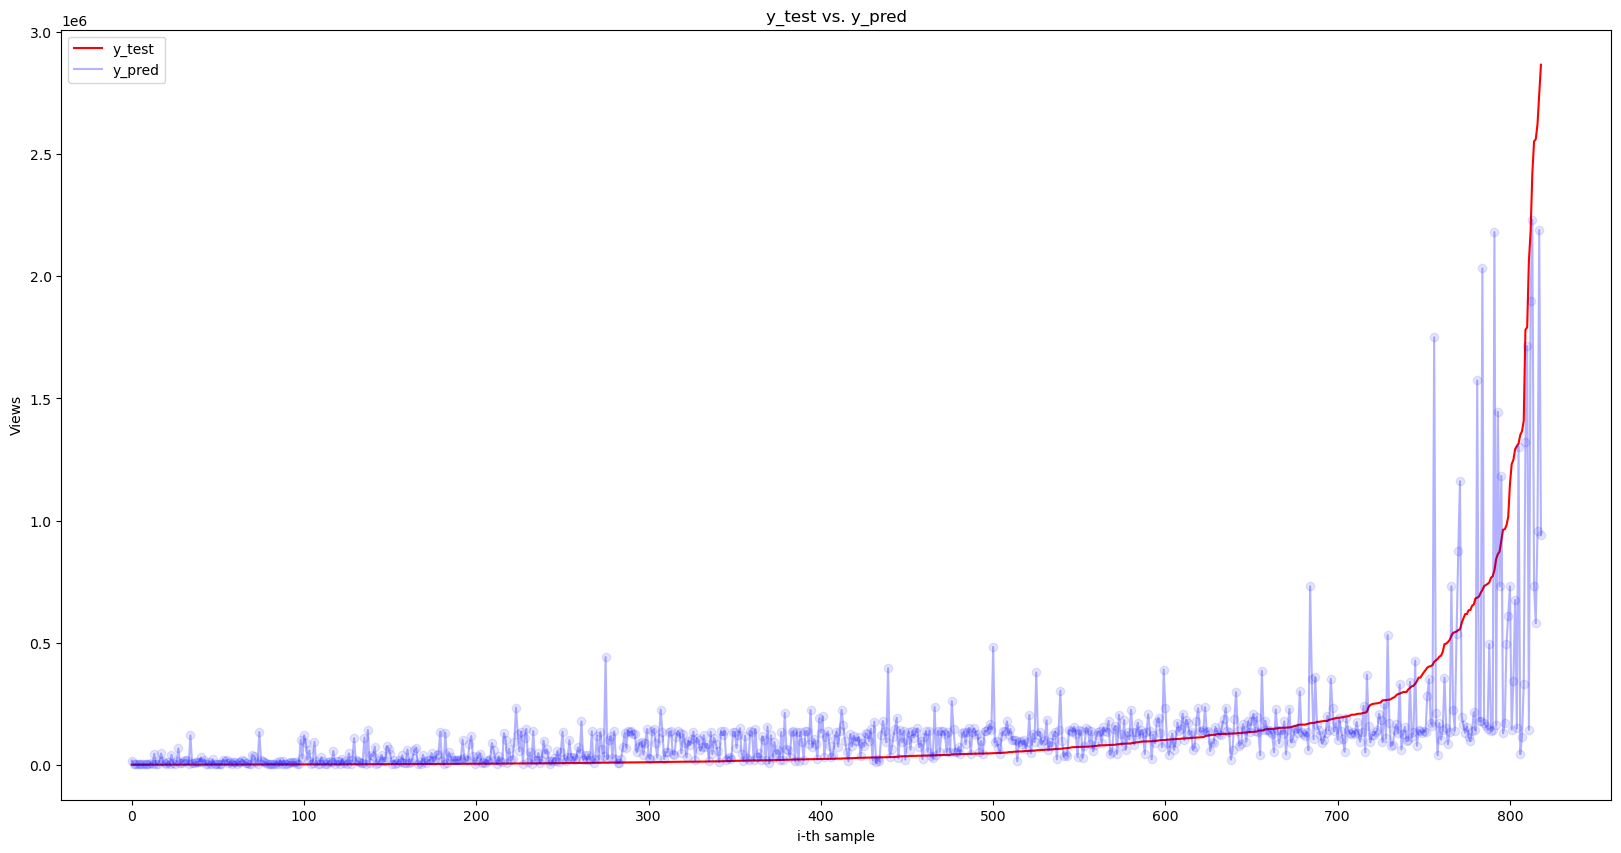

In [22]:
df_pred_sorted = df_pred.sort_values('y_test')

fig, ax = plt.subplots(figsize = (20, 10))
x = np.arange(0, len(y_test))

ax.plot(x, df_pred_sorted['y_test'], "r", label = 'y_test')
ax.plot(x, df_pred_sorted['y_pred'], "b", alpha = 0.3, label = 'y_pred')
ax.plot(x, df_pred_sorted['y_pred'], "bo", alpha = 0.1)
ax.set_xlabel('i-th sample')
ax.set_ylabel('Views')
ax.set_title('y_test vs. y_pred')
ax.legend();

# Results analysis

The graph shows that the model's predictions are not very accurate overall. There are some points that are very close to the actual values, but there are also many points that are very far away. This suggests that the model is not able to generalize well to new data.

The model's accuracy also appears to decline as the sample index increases. This suggests that the model may be overfitting to the earlier samples in the dataset.

# Saving models for deployment

In [23]:
dump(model, '../models/model.joblib')
dump(mlb, '../deploy/materials/mlb.joblib')

['../deploy/materials/mlb.joblib']

# Conclusion

While video duration and tags provide significant insights into potential viewership, achieving truly accurate forecasts necessitates incorporating additional factors. Expanding the feature set with richer data points like sentiment analysis of viewer comments, or historical performance of similar videos could unlock a deeper understanding of audience engagement and lead to significantly more refined predictions.